<a href="https://colab.research.google.com/github/nferrucho/NPL/blob/main/curso2/ciclo3/Ejemplo_pr%C3%A1ctico_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Data Load

In [ ]:
import numpy as np
import keras
import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import os

Subimos un conjunto de imágenes a través del archivo `birds.zip` (lo cargamos directamente). Necesitamos descomprimirlo:

In [ ]:
!unzip birds.zip

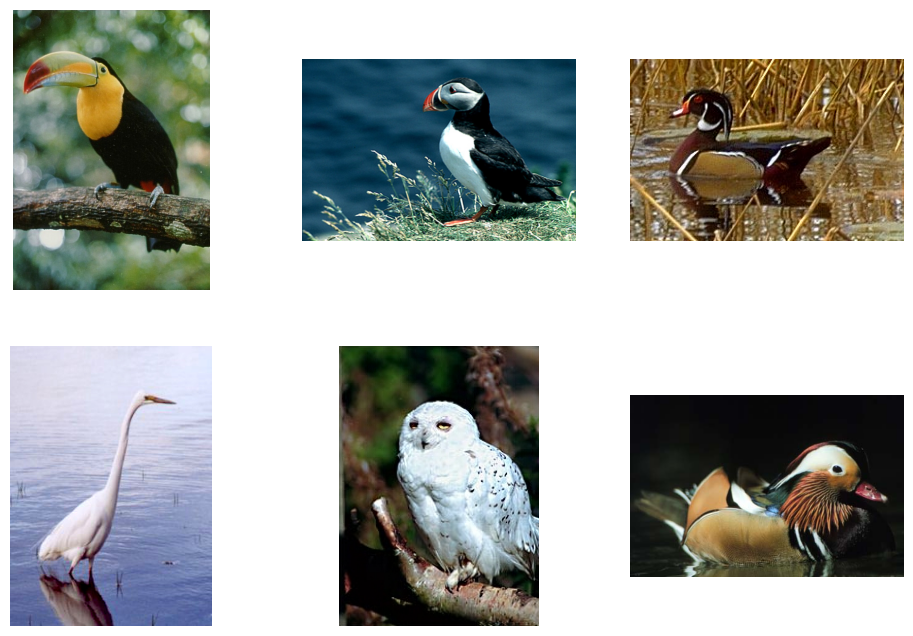

In [ ]:
image_paths = ['birds/toucan/tou027.jpg',
               'birds/puffin/puf076.jpg',
               'birds/wood_duck/wod009.jpg',
               'birds/egret/egr048.jpg',
               'birds/owl/owl022.jpg',
               'birds/mandarin/man083.jpg']


fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, image_path in enumerate(image_paths):
    img = mpimg.imread(image_path)
    row = i // 3
    col = i % 3
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

plt.show()

## Canales de color

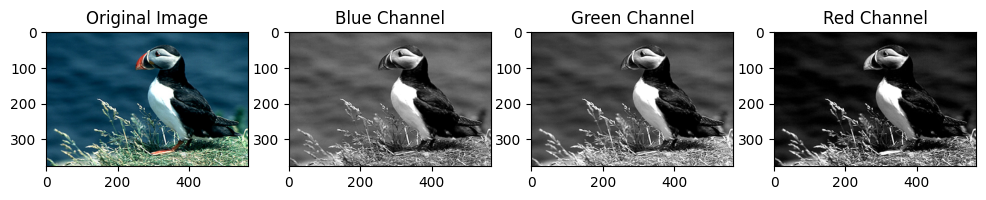

In [ ]:
image = mpimg.imread('birds/puffin/puf076.jpg')

if image is None:
    print("Error: Could not load the image.")
else:
    red_channel = image[:, :, 0]
    green_channel = image[:, :, 1]
    blue_channel = image[:, :, 2]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title("Original Image")

    plt.subplot(1, 4, 2)
    plt.imshow(blue_channel, cmap='gray')
    plt.title("Blue Channel")

    plt.subplot(1, 4, 3)
    plt.imshow(green_channel, cmap='gray')
    plt.title("Green Channel")

    plt.subplot(1, 4, 4)
    plt.imshow(red_channel, cmap='gray')
    plt.title("Red Channel")

    plt.show()

## Data Augmentation

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator


img = load_img('birds/toucan/tou027.jpg')
x = img_to_array(img)
print(x.shape)
x = x.reshape((1,) + x.shape)
print(x.shape)

(658, 461, 3)
(1, 658, 461, 3)


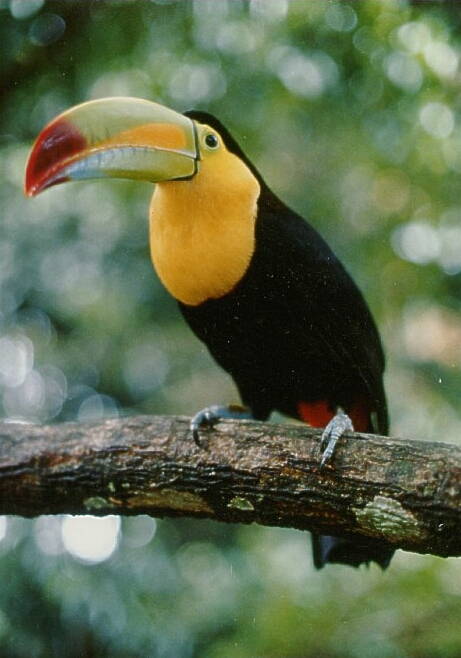

In [ ]:
img

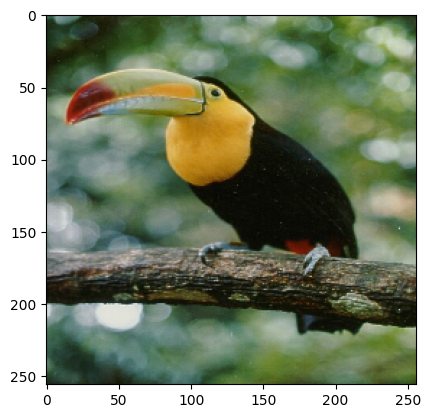

In [ ]:
IMG_SIZE = 256

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

result = resize_and_rescale(x[0])
plt.imshow(result)

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

img = load_img('birds/toucan/tou027.jpg')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
    i += 1
    if i > 5:
        break
    plt.imshow(batch[0]/255)
    plt.show()

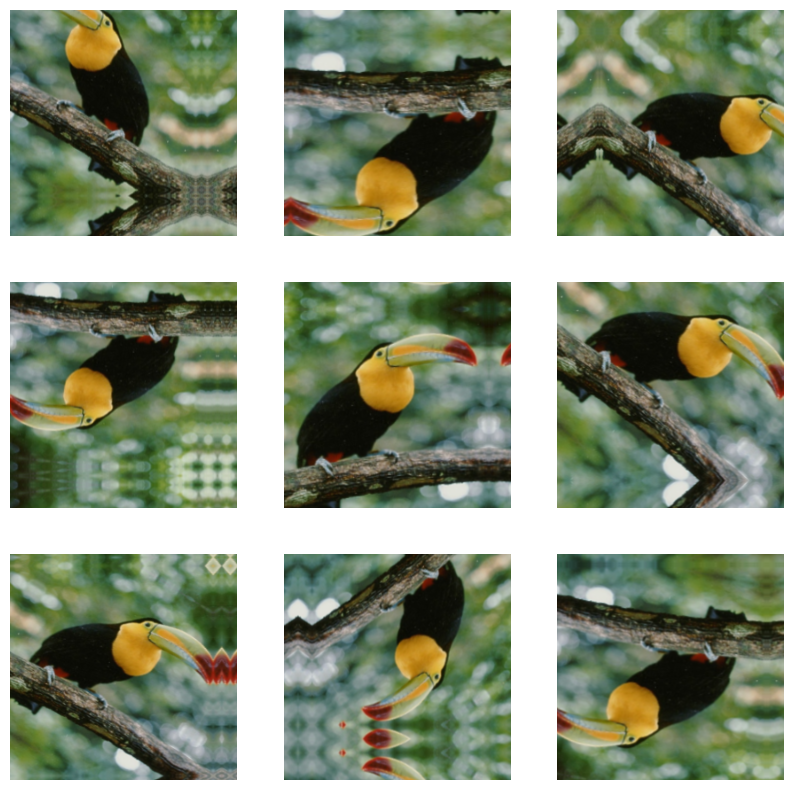

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(1/8, fill_mode="reflect"),
  layers.RandomZoom(0.2),
  layers.RandomTranslation(0.2, 0.2, fill_mode="reflect")
])

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented = data_augmentation(result)
  ax = plt.subplot(3, 3, i + 1)
  ax.imshow(augmented)
  plt.axis("off")

## Red desde cero

In [ ]:
ds = image_dataset_from_directory('/content/birds/', labels='inferred', batch_size=32)

Found 600 files belonging to 6 classes.


In [ ]:
ds.class_names

['egret', 'mandarin', 'owl', 'puffin', 'toucan', 'wood_duck']

In [ ]:
len(ds)

19

In [ ]:
# ALEXNET IMPLEMENTATION

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='tanh'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='tanh'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(6, activation='softmax')
])

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.optimizers.SGD(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()

In [ ]:
val_size = int(0.2 * len(ds))

train_ds = ds.skip(val_size)
val_ds = ds.take(val_size)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    verbose=2
)

In [ ]:
model.evaluate(val_ds)